# Basic ML algorithms


Goals of this notebook:
- Create a pytorch data loader
- Normalize data in the dataloader
- Run KNN algorithm
- Just explore data in general, see what we have



From GIS:
- DEM: Elevation map
- Curvature
- Aspect
- Slope angle  
- Stream density
- Distances from the stream network
- Topographic wetness index (TWI)

From geology data:
- Lithology map

From flood inventory:
- flood map: coordinates -> map

### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba
import seaborn as sns

from scipy import ndimage

import geopandas as gpd

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras

In [ ]:
from xgboost import XGBClassifier

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 7.9 MB/s eta 0:00:00


In [ ]:
import shap

## Load and normalize data

### Data path

In [ ]:
data_path = "/content/drive/MyDrive/PROJECT ML/ProcessedData"
plot_path = "/content/drive/MyDrive/PROJECT ML/plots"
output_path = "/content/drive/MyDrive/PROJECT ML/Outputs"

In [ ]:
def load_array_from_npy(name):
    return np.load(os.path.join(data_path, f"{name}.npy"))

In [ ]:
def save_array_as_npy(array, name):
    output_fn = os.path.join(output_path, f"{name}.npy")

    print(f"shape of {name}", array.shape)
    print("saved to", output_fn)

    np.save(output_fn, array)

### Loading all maps

In [ ]:
shape_mask = load_array_from_npy("shape_mask")

In [ ]:
elevation = load_array_from_npy("elevation")

In [ ]:
curvature = load_array_from_npy("curvature")

In [ ]:
bin_curvature = load_array_from_npy("bin_curvature")

In [ ]:
aspect_deg = load_array_from_npy("aspect_deg")

In [ ]:
bin_aspect = load_array_from_npy("bin_aspect")

In [ ]:
aspect_flat = load_array_from_npy("aspect_flat")

In [ ]:
slope_angle_deg = load_array_from_npy("slope_angle")

In [ ]:
stream_density = load_array_from_npy("stream_density")

In [ ]:
distance_to_stream = load_array_from_npy("distance_to_stream")

In [ ]:
twi = load_array_from_npy("twi")

In [2]:
soil_map = load_array_from_npy("soil_map")

NameError: ignored

### Normalize the maps

In [ ]:
print('shape of map', shape_mask.shape)
print('elevation:', 'OK' if elevation.shape == shape_mask.shape else 'ERROR')
print('curvature:', 'OK' if curvature.shape == shape_mask.shape else 'ERROR')
print('bin_curvature:', 'OK' if bin_curvature.shape == shape_mask.shape else 'ERROR')
print('aspect_deg:', 'OK' if aspect_deg.shape == shape_mask.shape else 'ERROR')
print('bin_aspect:', 'OK' if bin_aspect.shape == shape_mask.shape else 'ERROR')
print('aspect_flat:', 'OK' if aspect_flat.shape == shape_mask.shape else 'ERROR')
print('slope_angle_deg:', 'OK' if slope_angle_deg.shape == shape_mask.shape else 'ERROR')
print('stream_density:', 'OK' if stream_density.shape == shape_mask.shape else 'ERROR')
print('distance_to_stream:', 'OK' if distance_to_stream.shape == shape_mask.shape else 'ERROR')
print('twi:', 'OK' if twi.shape == shape_mask.shape else 'ERROR')
print('soil_map:', 'OK' if soil_map.shape == shape_mask.shape else 'ERROR')

shape of map (3106, 3862)
elevation: OK
curvature: OK
bin_curvature: OK
aspect_deg: OK
bin_aspect: OK
aspect_flat: OK
slope_angle_deg: OK
stream_density: OK
distance_to_stream: OK
twi: OK
soil_map: OK


#### DEFINING A NEW shape_mask
ONLY USING ELEVATION VALUES < 0

In [ ]:
shape_mask = (elevation < 0)

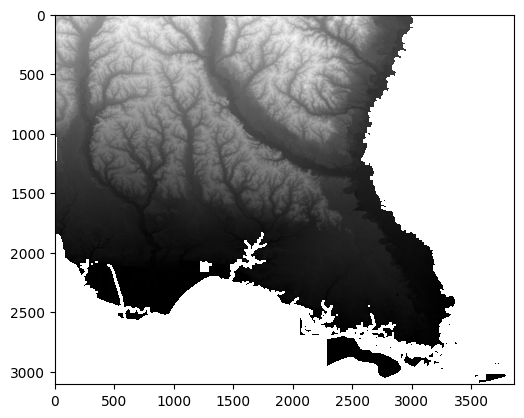

In [ ]:
masked_elevation = np.ma.array(elevation, mask = shape_mask)
plt.imshow(masked_elevation, cmap='gray')
plt.show()

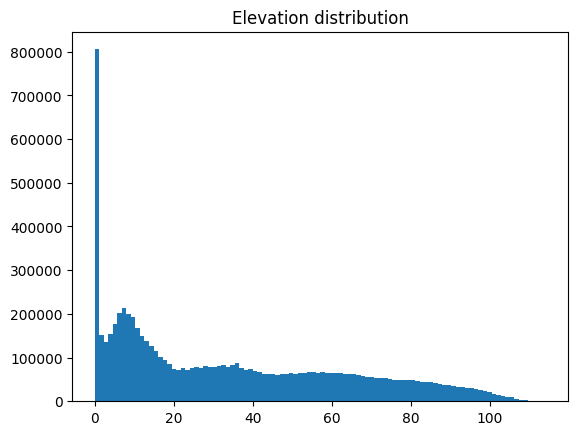

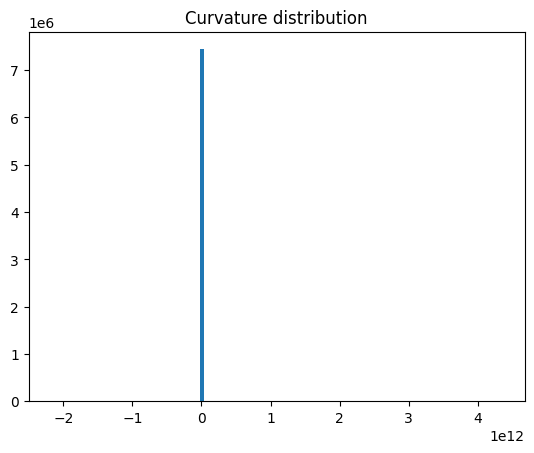

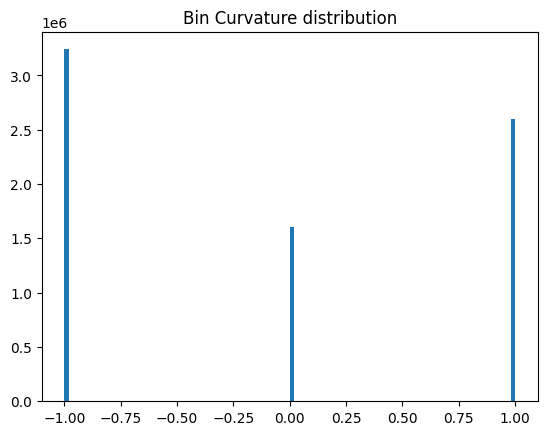

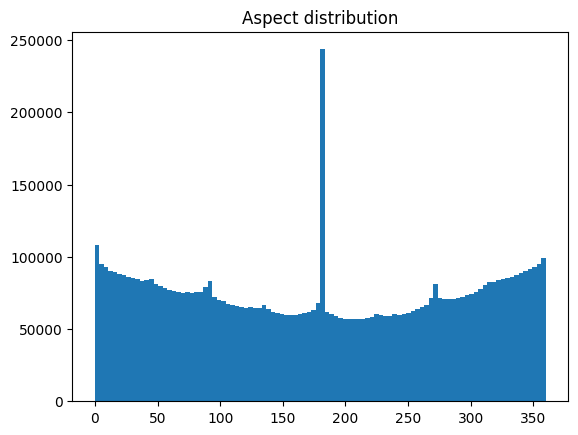

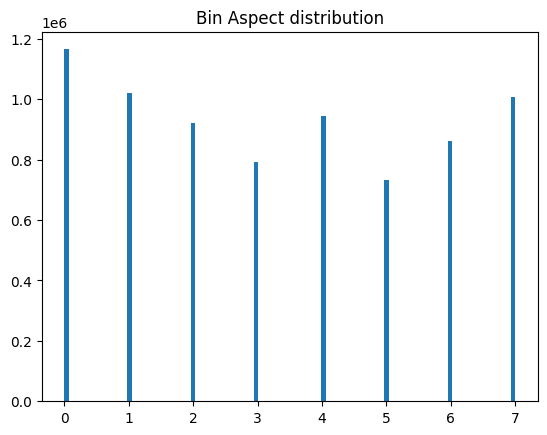

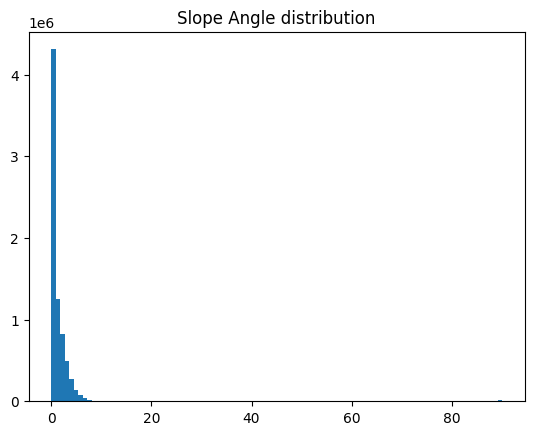

In [ ]:
plt.hist(elevation[~shape_mask], bins=100)
plt.title("Elevation distribution")
plt.show()

plt.hist(curvature[~shape_mask], bins=100)
plt.title("Curvature distribution")
plt.show()

plt.hist(bin_curvature[~shape_mask], bins=100)
plt.title("Bin Curvature distribution")
plt.show()

plt.hist(aspect_deg[~shape_mask], bins=100)
plt.title("Aspect distribution")
plt.show()

plt.hist(bin_aspect[~shape_mask], bins=100)
plt.title("Bin Aspect distribution")
plt.show()

plt.hist(slope_angle_deg[~shape_mask], bins=100)
plt.title("Slope Angle distribution")
plt.show()

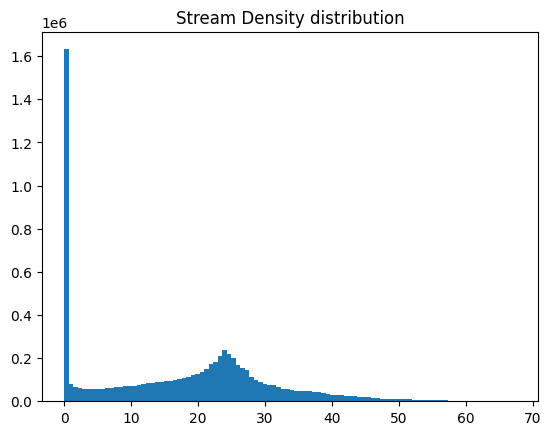

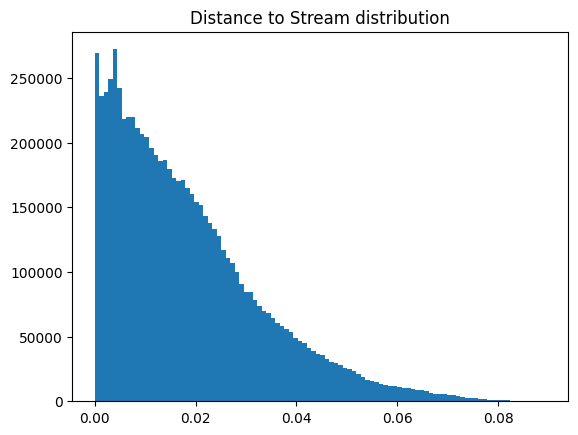

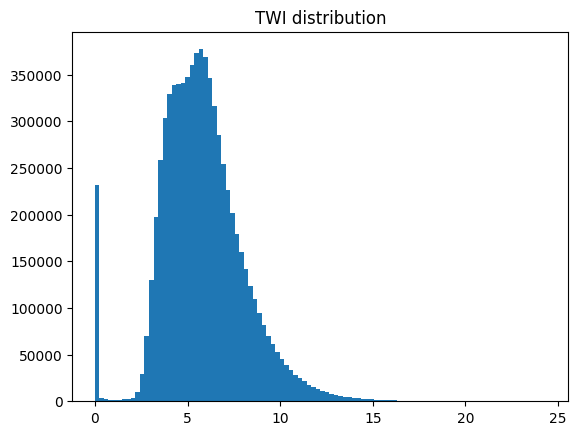

In [ ]:
plt.hist(stream_density[~shape_mask], bins=100)
plt.title("Stream Density distribution")
plt.show()

plt.hist(distance_to_stream[~shape_mask], bins=100)
plt.title("Distance to Stream distribution")
plt.show()

plt.hist(twi[~shape_mask], bins=100)
plt.title("TWI distribution")
plt.show()

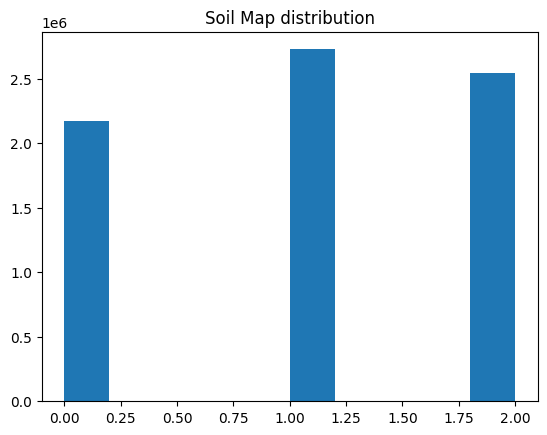

In [ ]:
plt.hist(soil_map[~shape_mask], bins=10)
plt.title("Soil Map distribution")
plt.show()

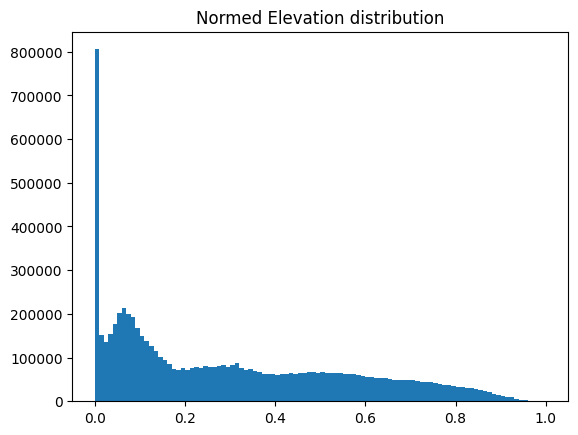

In [ ]:
elev_min = elevation[~shape_mask].min()
elev_max = elevation[~shape_mask].max()

norm_elevation = (elevation - elev_min) / (elev_max - elev_min)

norm_elevation[shape_mask] = norm_elevation[~shape_mask].mean()
plt.hist(norm_elevation[~shape_mask], bins=100)
#plt.hist(norm_elevation.flatten(), bins=100)
plt.title("Normed Elevation distribution")
plt.show()

In [ ]:
#norm_bin_curvature = np.array([bin_curvature < -0.5,
#                               (bin_curvature >= -0.5) & (bin_curvature <= 0.5),
#                               bin_curvature > 0.5]).astype(int).transpose(1,2,0)
norm_bin_curvature = -1 * (bin_curvature < -0.5) + 1*(bin_curvature > 0.5)

print(norm_bin_curvature.shape)
print(np.unique(norm_bin_curvature, return_counts=True))

(3106, 3862)
(array([-1,  0,  1]), array([3280720, 6084308, 2630344]))


(3106, 3862, 2)


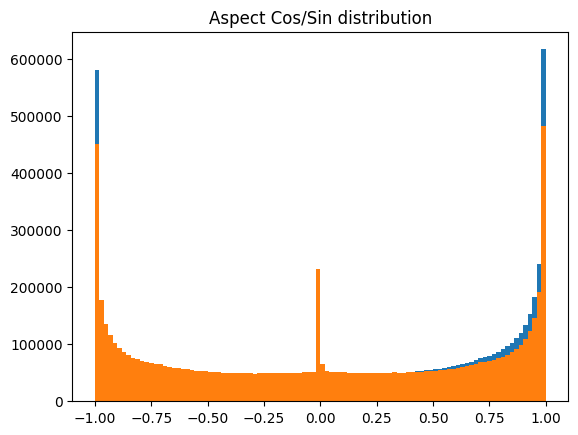

In [ ]:
aspect_cos = np.cos(np.radians(aspect_deg))
aspect_sin = np.sin(np.radians(aspect_deg))

norm_aspect = np.dstack((aspect_cos, aspect_sin))

print(norm_aspect.shape)

norm_aspect[shape_mask] *= 0

plt.hist(norm_aspect[:,:,0][~shape_mask], bins=100)
plt.hist(norm_aspect[:,:,1][~shape_mask], bins=100)
plt.title("Aspect Cos/Sin distribution")
plt.show()

In [ ]:
# One-hot encoding of bin_aspect
norm_bin_aspect = np.eye(8)[bin_aspect]

norm_aspect[shape_mask] *= 0
print(norm_bin_aspect.shape)

(3106, 3862, 8)


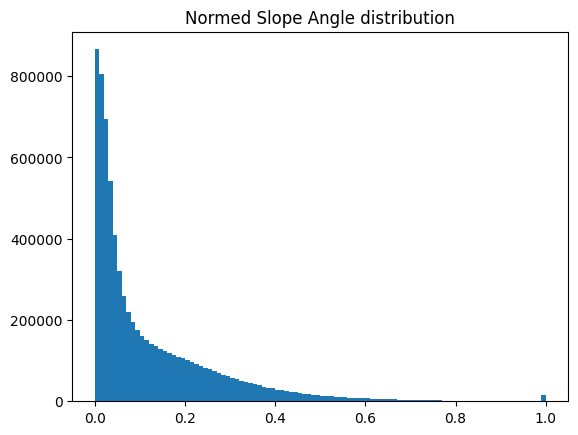

In [ ]:
norm_slope_angle_deg = np.clip(slope_angle_deg, 0, 10)

slope_min = norm_slope_angle_deg[~shape_mask].min()
slope_max = norm_slope_angle_deg[~shape_mask].max()

norm_slope_angle_deg = (norm_slope_angle_deg - slope_min) / (slope_max - slope_min)

norm_slope_angle_deg[shape_mask] = norm_slope_angle_deg[~shape_mask].mean()

plt.hist(norm_slope_angle_deg[~shape_mask], bins=100)
plt.title("Normed Slope Angle distribution")
plt.show()

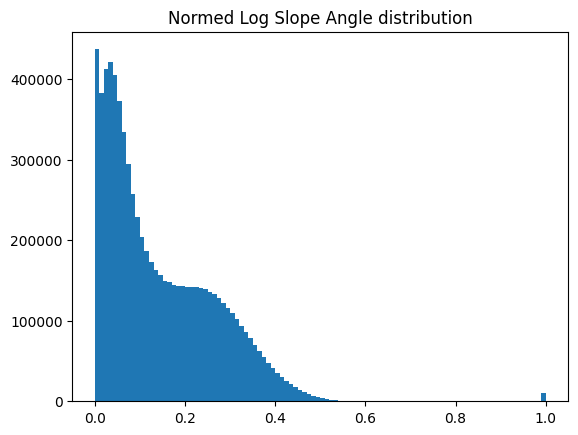

In [ ]:
# log normalize slope

log_slope = np.log(1+slope_angle_deg)

slope_min = log_slope[~shape_mask].min()
slope_max = log_slope[~shape_mask].max()

norm_log_slope = (log_slope - slope_min) / (slope_max - slope_min)

norm_log_slope[shape_mask] = norm_log_slope[~shape_mask].mean()

plt.hist(norm_log_slope[~shape_mask], bins=100)
plt.title("Normed Log Slope Angle distribution")
plt.show()

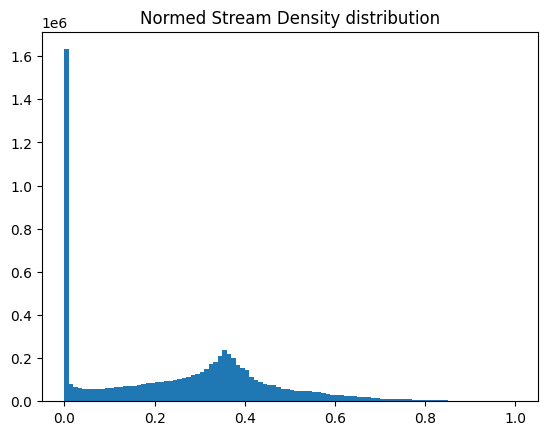

In [ ]:
# normalize stream density
stream_density_min = stream_density[~shape_mask].min()
stream_density_max = stream_density[~shape_mask].max()

norm_stream_density = (stream_density - stream_density_min) / (stream_density_max - stream_density_min)

norm_stream_density[shape_mask] = norm_stream_density[~shape_mask].mean()

plt.hist(norm_stream_density[~shape_mask], bins=100)
plt.title("Normed Stream Density distribution")
plt.show()

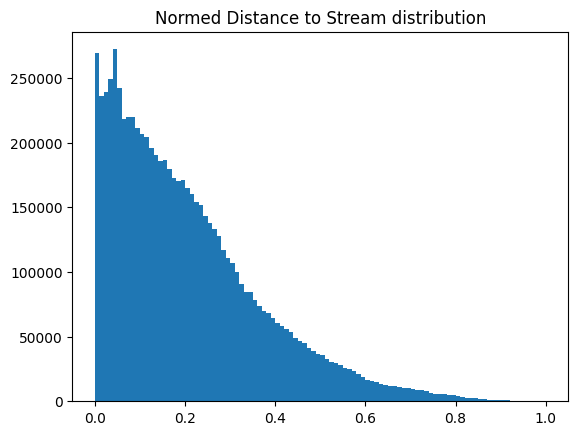

In [ ]:
# normalize distance to stream
distance_to_stream_min = distance_to_stream[~shape_mask].min()
distance_to_stream_max = distance_to_stream[~shape_mask].max()

norm_distance_to_stream = (distance_to_stream - distance_to_stream_min) / (distance_to_stream_max - distance_to_stream_min)

norm_distance_to_stream[shape_mask] = norm_distance_to_stream[~shape_mask].mean()

plt.hist(norm_distance_to_stream[~shape_mask], bins=100)
plt.title("Normed Distance to Stream distribution")
plt.show()

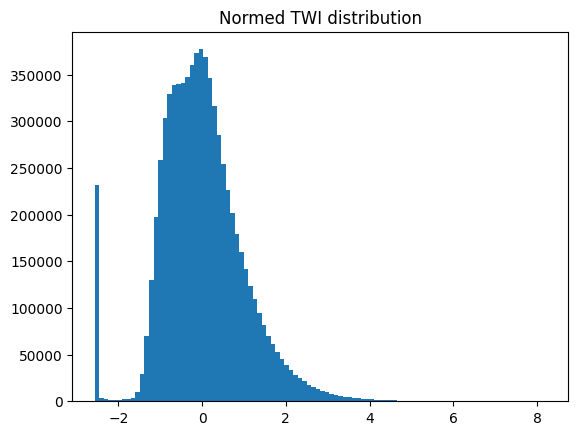

In [ ]:
# standardize twi
twi_mean = twi[~shape_mask].mean()
twi_std = twi[~shape_mask].std()

norm_twi = (twi - twi_mean) / twi_std

norm_twi[shape_mask] = norm_twi[~shape_mask].mean()

plt.hist(norm_twi[~shape_mask], bins=100)
plt.title("Normed TWI distribution")
plt.show()

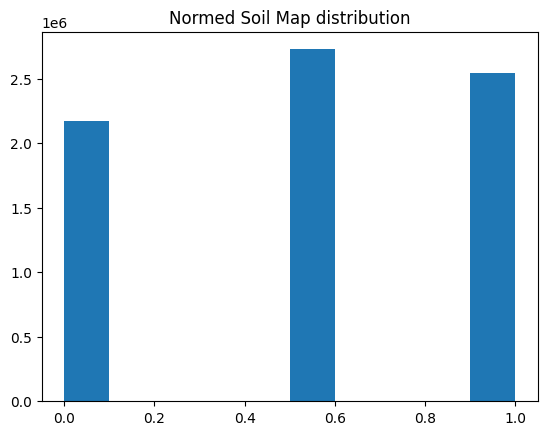

In [ ]:
norm_soil = soil_map / 2

plt.hist(norm_soil[~shape_mask], bins=10)
plt.title("Normed Soil Map distribution")
plt.show()

In [ ]:
data_map = np.dstack((
    norm_elevation,
    norm_bin_curvature,
    norm_aspect,
    #norm_bin_aspect,
    norm_slope_angle_deg,
    #norm_log_slope,
    norm_stream_density,
    norm_distance_to_stream,
    norm_twi,
    norm_soil
))

data_map.shape

(3106, 3862, 9)

### Loading flood inventory

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(os.path.join(data_path, "flood_idx.csv"))
len(df)

252

In [ ]:
flood_map = np.zeros_like(shape_mask)
flood_map[df.to_numpy()[:,0],
          df.to_numpy()[:,1]] = 1
flood_map.shape

(3106, 3862)

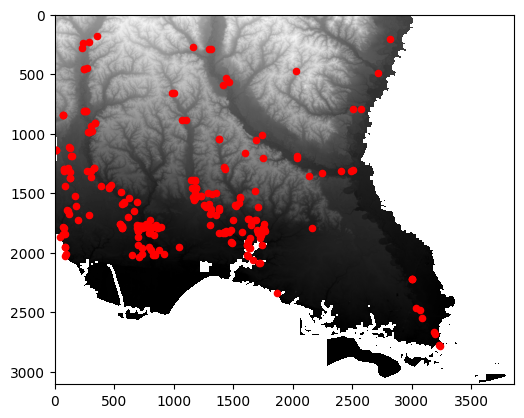

In [ ]:
masked_elevation = np.ma.array(elevation, mask = shape_mask)
plt.imshow(masked_elevation, cmap='gray')
plt.scatter(df.to_numpy()[:,1], df.to_numpy()[:,0],
            c='r', s=20)
plt.show()

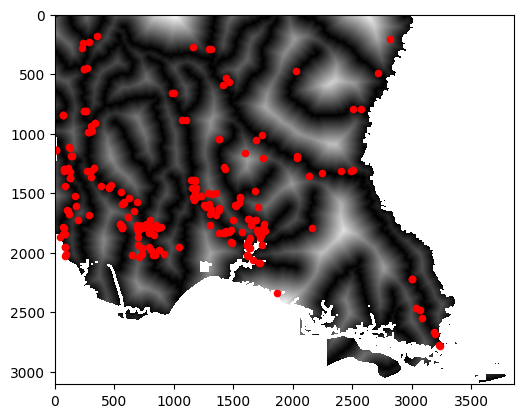

In [ ]:
masked_distance_to_stream = np.ma.array(distance_to_stream, mask = shape_mask)
plt.imshow(masked_distance_to_stream, cmap='gray')
plt.scatter(df.to_numpy()[:,1], df.to_numpy()[:,0],
            c='r', s=20)
plt.show()

### Data science framework

In [ ]:
flood_map.dtype

dtype('bool')

In [ ]:
kernel_size = 5
y,x = np.ogrid[-kernel_size: kernel_size+1, -kernel_size: kernel_size+1]
kernel = x**2+y**2 <= kernel_size**2

kernel

array([[False, False, False, False, False,  True, False, False, False,
        False, False],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
        False, False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
        False, False],
       [False, False, False, False, False,  True, False, Fal

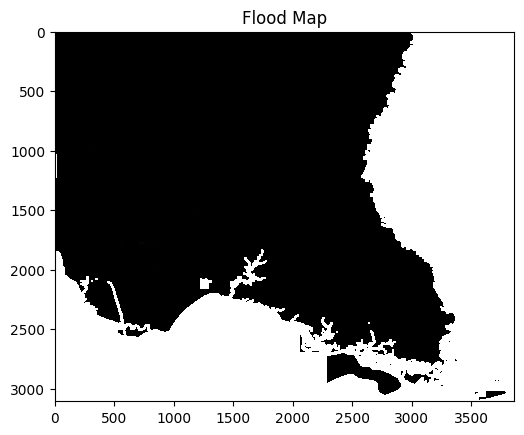

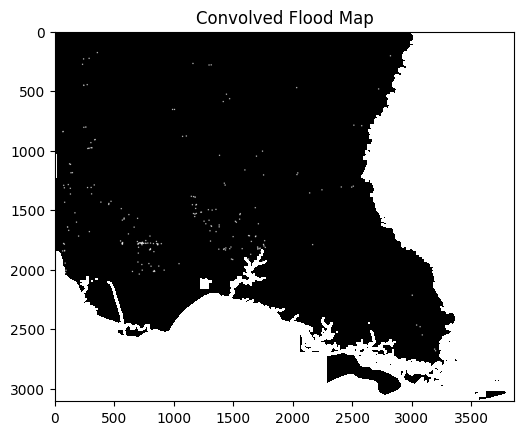

In [ ]:
from scipy.signal import convolve2d

conv_flood_map = convolve2d(flood_map.astype(int), kernel, mode='same').astype(bool)

masked_flood_map = np.ma.array(flood_map, mask = shape_mask)
plt.imshow(masked_flood_map, cmap='gray')
plt.title("Flood Map")
plt.show()

masked_conv_flood_map = np.ma.array(conv_flood_map, mask = shape_mask)
plt.imshow(masked_conv_flood_map, cmap='gray')
plt.title("Convolved Flood Map")
plt.show()

In [ ]:
X = data_map[~shape_mask]
y = conv_flood_map[~shape_mask]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"There are {np.count_nonzero(y)} flood pixels out of {y.shape[0]}...")

X shape: (7442458, 9)
y shape: (7442458,)
There are 17085 flood pixels out of 7442458...


In [ ]:
X = data_map[~shape_mask]
y = flood_map[~shape_mask]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"There are {np.count_nonzero(y)} flood pixels out of {y.shape[0]}...")

X shape: (7442458, 9)
y shape: (7442458,)
There are 233 flood pixels out of 7442458...


## Machine Learning stuff

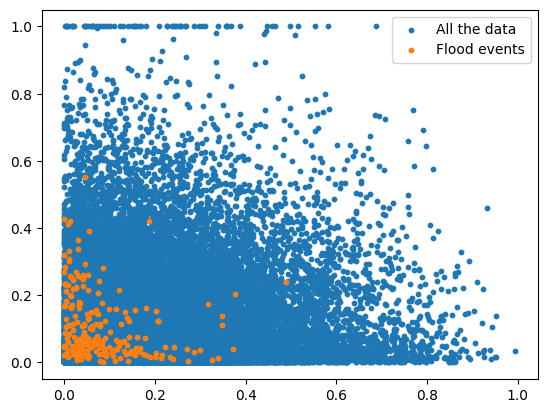

In [ ]:
# scatter data using the supposedly two most important features

n = 30_000
s = 10
plt.scatter(np.random.choice(norm_distance_to_stream[~shape_mask],
                             size=n,
                             replace=False),
            np.random.choice(norm_slope_angle_deg[~shape_mask],
                             size=n,
                             replace=False),
            label="All the data",
            s=s)

plt.scatter(norm_distance_to_stream[flood_map],
            norm_slope_angle_deg[flood_map],
            label="Flood events",
            s=s)

plt.legend()
plt.show()

### Utils

In [ ]:
def select_points(X, y, n_datapoints, seed=None,
                  reproduce_my_stupid_mistake=False):
    """
    Select n_datapoints from X and y by keeping all flood pixels
    and randomly selecting the dry pixels
    """
    if seed is not None:
        np.random.seed(seed)

    n_flood = np.count_nonzero(y)
    points_idx = np.argsort(~y)
    X_flood = X[points_idx[:n_flood]]
    y_flood = y[points_idx[:n_flood]]

    selected_idx = np.random.choice(points_idx[n_flood:],
                                    size=n_datapoints-n_flood,
                                    replace=False)

    # just for fun
    if reproduce_my_stupid_mistake:
        selected_idx = points_idx[n_flood:][:n_datapoints-n_flood]

    X_dry = X[selected_idx]
    y_dry = y[selected_idx]

    X_select = np.concatenate([X_flood, X_dry])
    y_select = np.concatenate([y_flood, y_dry])

    np.random.shuffle(X_select)
    np.random.shuffle(y_select)

    return X_select, y_select

In [ ]:
def boost_flood(X_train, y_train, nb_flood_rep):
    """
    Boost the frequency of flood pixels in the training set
    """
    n_flood = np.count_nonzero(y_train)
    flood_points = np.argsort(~y_train)[:n_flood]
    to_concat = (nb_flood_rep-1) * [flood_points] + [np.argsort(y_train)]

    selected_points = np.concatenate(to_concat)
    X_boost = X_train[selected_points]
    y_boost = y_train[selected_points]

    np.random.shuffle(X_boost)
    np.random.shuffle(y_boost)

    return X_boost, y_boost

In [ ]:
def plot_history(history, loss_name='Mean squared error'):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(loss_name)
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()

In [ ]:
def performance_metrics(y_pred, y_test):
    return {
        'f1': f1_score(y_test, y_pred > 0.5),
        'recall': recall_score(y_test, y_pred > 0.5),
        'precision': precision_score(y_test, y_pred > 0.5),
        'confusion_matrix': confusion_matrix(y_test, y_pred > 0.5,
                                             normalize='true'),
    }

In [ ]:
def plot_result_map(result_map, title, colorbar_label=None,
                    figsize=(8, 6), filename=None,
                    cmap='viridis',
                    scatter_df=True):
    fig, ax = plt.subplots(figsize=figsize)

    masked_result_map = np.ma.array(result_map, mask = shape_mask)
    img = ax.imshow(masked_result_map, cmap=cmap)
    cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label(colorbar_label)

    if scatter_df:
        ax.scatter(df.to_numpy()[:,1],
                    df.to_numpy()[:,0],
                    c='r', s=20)

    plt.title(title)

    if filename is not None:
        plt.savefig(filename)
    plt.show()

*Comment on the performance metrics:* In flash floods prediction, we care more about avoiding Type II errors (false negative) than Type I errors (false positive). If we predict that a flash flood can occur somewhere but none occurs, it's fine. If we don't predict than a flash flood can occur but one occurs, that's a problem. We still need to avoid false positives of course, but not as much.
So, we want to reduce the number of false negatives to almost zero. And once that's reached, we try to reduce the number of false positives.

TLDR; Main priority: reduce False Negative



### PCA visualization

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# apply pca to the data
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

X_pca.shape

(7442458, 3)

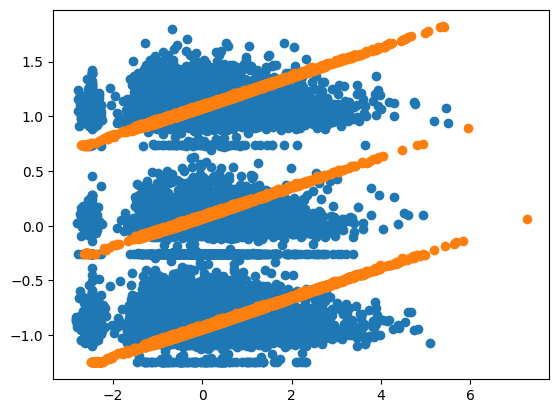

In [ ]:
n = 20_000
comp1 = 0
comp2 = 1

plt.scatter(np.random.choice(X_pca[~y, comp1],
                             size=n,
                             replace=False),
            np.random.choice(X_pca[~y, comp2],
                             size=n,
                             replace=False))

plt.scatter(X_pca[y,comp1],
            X_pca[y,comp2])

plt.show()

### Train test split

In [ ]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"There are {np.count_nonzero(y)} flood pixels")

X shape: (8300246, 16)
y shape: (8300246,)
There are 236 flood pixels


In [ ]:
X_select, y_select = select_points(X, y,
                                   n_datapoints=3000)

X_train, X_test, y_train, y_test = train_test_split(X_select,
                                                    y_select,
                                                    test_size=0.2,
                                                    random_state=42)

X_train, y_train = boost_flood(X_train, y_train,
                               nb_flood_rep=8)

print("Training set shape: ", X_train.shape, y_train.shape)
print("Test set shape: ", X_test.shape, y_test.shape)

Training set shape:  (3751, 16) (3751,)
Test set shape:  (600, 16) (600,)


### Neural Network

In [ ]:
n_datapoints = 3000
nb_flood_rep = 8

X_select, y_select = select_points(X, y, n_datapoints=n_datapoints)

X_train, X_test, y_train, y_test = train_test_split(X_select,
                                                    y_select,
                                                    test_size=0.2,
                                                    random_state=42)

X_train, y_train = boost_flood(X_train, y_train,
                               nb_flood_rep=nb_flood_rep)

print("Training set shape: ", X_train.shape, y_train.shape)
print("Test set shape: ", X_test.shape, y_test.shape)

Training set shape:  (3695, 16) (3695,)
Test set shape:  (600, 16) (600,)


In [ ]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu' #'linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
num_epochs     = 500
learning_rate  = 0.001
batch_size = 32
N_layers       = 3 # number of hidden layers

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
# let us build a neural network from scratch
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,
                name="hidden_layer_1",
                input_shape=(X_train.shape[1],)))
for n in range(N_layers-1):
    model.add(Dense(n_neuron, activation=activation,
                    name="hidden_layer_"+str(n+2)))

model.add(Dense(1,  activation='sigmoid', name="output_layer")) # the output layer

model.compile(loss=loss, optimizer=optimizer)

In [ ]:
%%time

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

history = model.fit(X_train, y_train,
                    batch_size      = batch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2,
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/500
93/93 [==============================] - 1s 4ms/step - loss: 0.6796 - val_loss: 0.6775
Epoch 2/500
93/93 [==============================] - 0s 3ms/step - loss: 0.6726 - val_loss: 0.6769
Epoch 3/500
93/93 [==============================] - 0s 2ms/step - loss: 0.6719 - val_loss: 0.6764
Epoch 4/500
93/93 [==============================] - 0s 3ms/step - loss: 0.6691 - val_loss: 0.6762
Epoch 5/500
93/93 [==============================] - 0s 2ms/step - loss: 0.6683 - val_loss: 0.6753
Epoch 6/500
93/93 [==============================] - 0s 2ms/step - loss: 0.6676 - val_loss: 0.6756
Epoch 7/500
93/93 [==============================] - 0s 2ms/step - loss: 0.6655 - val_loss: 0.6723
Epoch 8/500
93/93 [==============================] - 0s 3ms/step - loss: 0.6657 - val_loss: 0.6736
Epoch 9/500
93/93 [==============================] - 0s 2ms/step - loss: 0.6647 - val_loss: 0.6774
Epoch 10/500
93/93 [==============================] - 0s 2ms/step - loss: 0.6633 - val_loss: 0.6742
Epoch 11/

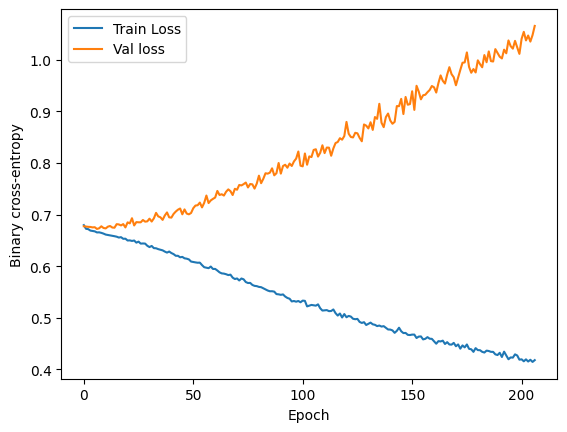

In [ ]:
plot_history(history, loss_name='Binary cross-entropy')

In [ ]:
y_pred = model.predict(X_test)

19/19 [==============================] - 0s 1ms/step


In [ ]:
%%time
y_pred = model.predict(X)

232577/232577 [==============================] - 359s 2ms/step
CPU times: user 8min 1s, sys: 24.8 s, total: 8min 26s
Wall time: 8min 25s


In [ ]:
y_pred.shape

NameError: ignored

In [ ]:
result_map = np.zeros_like(shape_mask, dtype=y_pred.dtype)

result_map[~shape_mask] = y_pred.squeeze()

In [ ]:
np.sum(y_pred), np.sum(result_map)

(2926131.2, 2926134.2)

In [ ]:
fn = f"nn_boost_{nb_flood_rep}"
save_array_as_npy(result_map, fn)

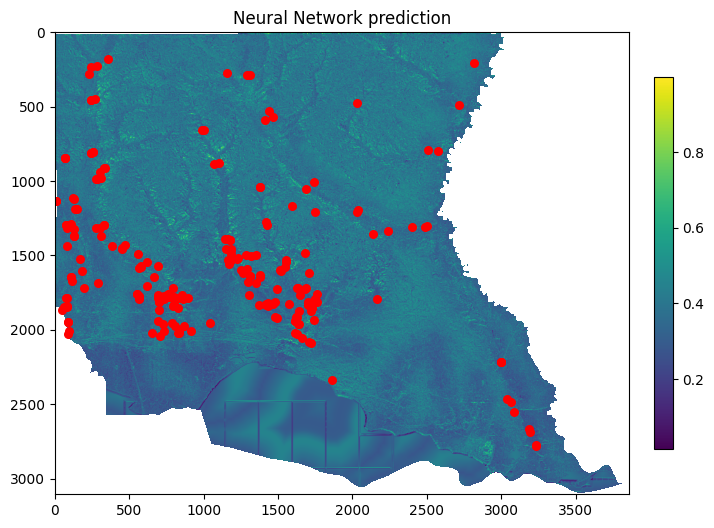

In [ ]:
plot_result_map(result_map,
                title='Neural Network prediction',
                colorbar_label='Probability of flooding')

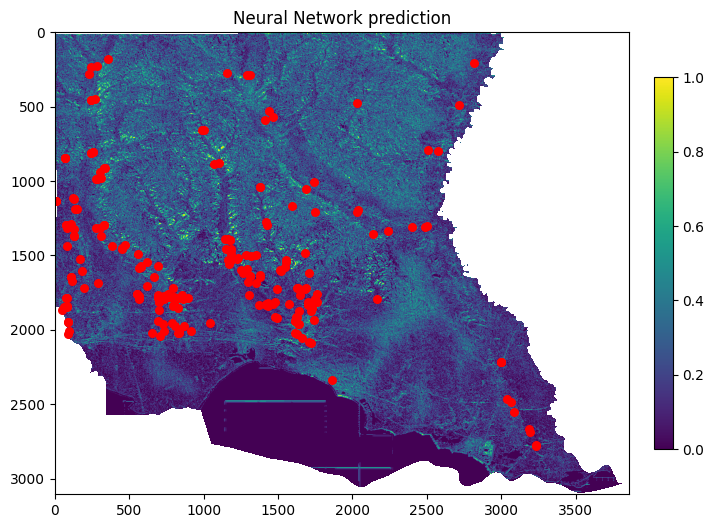

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

masked_result_map = np.ma.array(result_map, mask = shape_mask)
img = ax.imshow(masked_result_map > 0.5) #, cmap='Blues')
cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.04)
#cbar.set_label('')

ax.scatter(df.to_numpy()[:,1],
            df.to_numpy()[:,0],
            c='r', s=30)

plt.title('Neural Network prediction')
plt.show()

### XGBoost

In [ ]:
params = [(4, 6, 100),
          (2, 6, 100),
          (4, 4, 100),
          (4, 8, 100),
          (8, 8, 100),
          #(8, 10, 100),
          #(15, 6, 100)
          ]

boost_param, max_depth, scale_pos_weight = params[-1]
n_points = 1_000 * boost_param

#boost_param = 3
#max_depth = 6
#scale_pos_weight = 1
#n_points = 50_000

In [ ]:
X_select, y_select = select_points(X, y, n_points)

X_train, X_test, y_train, y_test = train_test_split(X_select,
                                                    y_select,
                                                    test_size=0.2,
                                                    random_state=42)

X_train, y_train = boost_flood(X_train, y_train, boost_param)
print("Training set shape: ", X_train.shape, y_train.shape)
print("Test set shape: ", X_test.shape, y_test.shape)
print(f"Number of flood pixels in training set: {np.count_nonzero(y_train)}")
print(f"Number of flood pixels in test set: {np.count_nonzero(y_test)}")

Training set shape:  (67380, 9) (67380,)
Test set shape:  (10000, 9) (10000,)
Number of flood pixels in training set: 41070
Number of flood pixels in test set: 3395


In [ ]:
%%time
clf = XGBClassifier(max_depth=max_depth,
                    scale_pos_weight=scale_pos_weight)
clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

CPU times: user 2.11 s, sys: 10.6 ms, total: 2.12 s
Wall time: 1.92 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
explainer = shap.KernelExplainer(model=clf.predict,
                                 data=shap.kmeans(X_test, 10),
                                 link="identity")

In [ ]:
%%time

shap_values = explainer.shap_values(X=X_test, nsamples=100)


  0%|          | 0/1600 [00:00<?, ?it/s]

CPU times: user 48.3 s, sys: 378 ms, total: 48.7 s
Wall time: 32.9 s


In [ ]:
shap_values.shape

(1600, 8)

In [ ]:
list_of_labels = ["elevation", "curvature", "aspect_cos", "aspect_sin",
            #"bin_aspect_N", "bin_aspect_NE", "bin_aspect_E", "bin_aspect_SE",
            #"bin_aspect_S", "bin_aspect_SW", "bin_aspect_W", "bin_aspect_NW",
            "slope_angle_deg", #"log_slope",
            "stream_density", "distance_to_stream",
            "twi"]

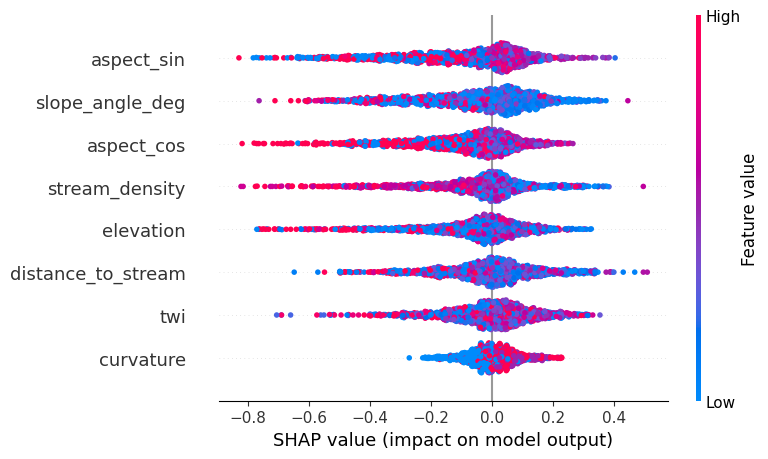

In [ ]:
shap.summary_plot(
    shap_values=shap_values,
    feature_names=list_of_labels,
    features=X_test,
    show=False
)

fn = f"shap_features_xgboost_boost_{boost_param}_max_depth_{max_depth}_scale_pos_weight_{scale_pos_weight}.png"
plt.savefig(os.path.join(plot_path, fn))

plt.show()

In [ ]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 45.4 ms, sys: 0 ns, total: 45.4 ms
Wall time: 30.2 ms


In [ ]:
np.mean(y_pred == y_test)

0.3727

In [ ]:
metrics = performance_metrics(y_pred, y_test)

print(f"Recall: {metrics['recall']:.2f}")

Recall: 0.92


In [ ]:
importances = clf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

In [ ]:
"""
0: elevation
1: curvature
2,3: aspect: cos and sin
4-11: bin_aspect: N, NE, E, SE, S, SW, W, NW
12: slope_angle_deg
13: log_slope
14: stream_density
15: distance_to_stream
16: twi
"""
features = ["elevation", "curvature", "aspect_cos", "aspect_sin",
            #"bin_aspect_N", "bin_aspect_NE", "bin_aspect_E", "bin_aspect_SE",
            #"bin_aspect_S", "bin_aspect_SW", "bin_aspect_W", "bin_aspect_NW",
            "slope_angle_deg", #"log_slope",
            "stream_density", "distance_to_stream",
            "twi", "soil"]

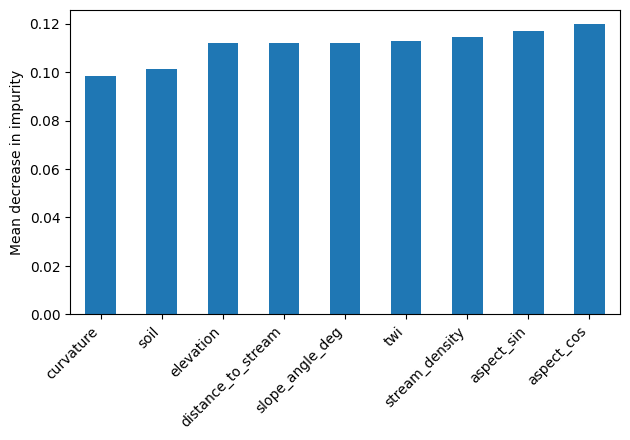

In [ ]:
pd_importances = pd.Series(importances, index=features)
pd_importances = pd_importances.sort_values()

fig, ax = plt.subplots()
pd_importances.plot.bar(ax=ax)
#ax.set_title("Feature importances using XGBoost")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.xticks(rotation=45, ha='right')

fn = f"features_xgboost_boost_{boost_param}_max_depth_{max_depth}_scale_pos_weight_{scale_pos_weight}.png"
plt.savefig(os.path.join(plot_path, fn))

plt.show()

In [ ]:
%%time
y_pred = clf.predict(X)

CPU times: user 25.7 s, sys: 62.2 ms, total: 25.7 s
Wall time: 15.9 s


In [ ]:
np.mean(y_pred == y)

0.08827392778031129

In [ ]:
result_map = np.zeros_like(shape_mask, dtype=y_pred.dtype)

result_map[~shape_mask] = y_pred

In [ ]:
np.sum(y_pred), np.sum(result_map)

(6799058, 6799058)

In [ ]:
fn = f"xgboost_boost_{boost_param}_max_depth_{max_depth}_scale_pos_weight_{scale_pos_weight}"
save_array_as_npy(result_map, fn)

shape of xgboost_boost_8_max_depth_8_scale_pos_weight_100 (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/Outputs/xgboost_boost_8_max_depth_8_scale_pos_weight_100.npy


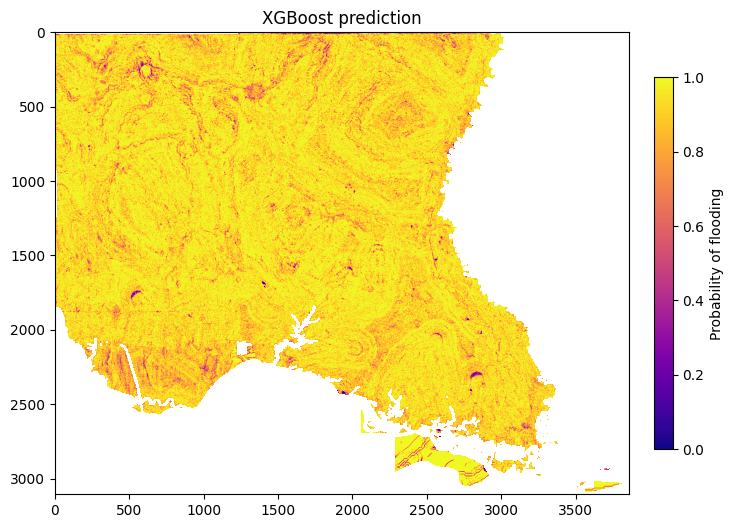

In [ ]:
plot_result_map(result_map,
                title='XGBoost prediction',
                colorbar_label='Probability of flooding',
                filename=os.path.join(plot_path, 'xgboost_map.png'),
                cmap='plasma',
                scatter_df=False)

### KNN

The model is way too consuming. I don't understand how it is supposed to work.

In [ ]:
X_select, y_select = select_points(X, y, 500)

X_train, X_test, y_train, y_test = train_test_split(X_select,
                                                    y_select,
                                                    test_size=0.2,
                                                    random_state=42)

print("Training set shape: ", X_train.shape, y_train.shape)
print("Test set shape: ", X_test.shape, y_test.shape)
print(f"Number of flood pixels in training set: {np.count_nonzero(y_train)}")
print(f"Number of flood pixels in test set: {np.count_nonzero(y_test)}")

Training set shape:  (400, 17) (400,)
Test set shape:  (100, 17) (100,)
Number of flood pixels in training set: 193
Number of flood pixels in test set: 40


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(15)
clf.fit(X_train, y_train)

#y_pred = clf.predict(X_test)


KNeighborsClassifier(n_neighbors=15)

In [ ]:
shape_mask.shape

(3106, 3862)

In [ ]:
np.sum((~shape_mask)[1500:2000, 1500:2000])

249075

In [ ]:
small_X = data_map[1500:2000, 1500:2000][(~shape_mask)[1500:2000, 1500:2000]]
small_X.shape

(249075, 17)

In [ ]:
%%time
y_pred = clf.predict(small_X)

CPU times: user 16.2 s, sys: 372 ms, total: 16.5 s
Wall time: 15.8 s


In [ ]:
small_result_map = np.zeros_like(shape_mask[1500:2000, 1500:2000], dtype=y_pred.dtype)

small_result_map[(~shape_mask)[1500:2000, 1500:2000]] = y_pred

result_map = np.zeros_like(shape_mask, dtype=y_pred.dtype)
result_map[1500:2000, 1500:2000] = small_result_map
result_map.shape

(3106, 3862)

In [ ]:
np.sum(y_pred), np.sum(result_map)

(105276, 105276)

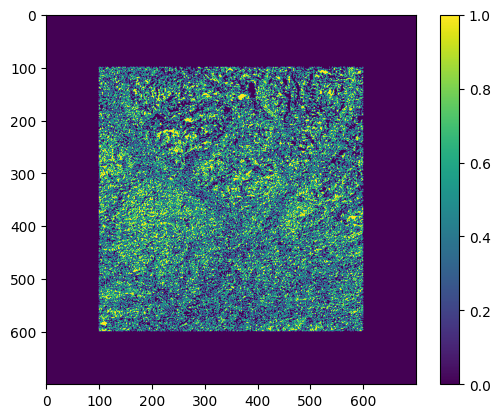

In [ ]:
# imshow the result

plt.imshow(result_map[1400:2100, 1400:2100]) #, cmap='Blues')
#plt.scatter(df.to_numpy()[:,1], df.to_numpy()[:,0], c='r', s=30)
plt.colorbar()
plt.show()

### Random Forest

In [ ]:
boost_param = 8
max_depth = 12

In [ ]:
X_select, y_select = select_points(X, y, 2000)

X_train, X_test, y_train, y_test = train_test_split(X_select,
                                                    y_select,
                                                    test_size=0.2,
                                                    random_state=42)

X_train, y_train = boost_flood(X_train, y_train, boost_param)
print("Training set shape: ", X_train.shape, y_train.shape)
print("Test set shape: ", X_test.shape, y_test.shape)
print(f"Number of flood pixels in training set: {np.count_nonzero(y_train)}")
print(f"Number of flood pixels in test set: {np.count_nonzero(y_test)}")

Training set shape:  (2923, 16) (2923,)
Test set shape:  (400, 16) (400,)
Number of flood pixels in training set: 1512
Number of flood pixels in test set: 44


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=max_depth, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, random_state=0)

In [ ]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 14.4 ms, sys: 0 ns, total: 14.4 ms
Wall time: 14.6 ms


In [ ]:
metrics = performance_metrics(y_pred, y_test)

print(f"Recall: {metrics['recall']:.2f}")

Recall: 0.64


In [ ]:
importances = clf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

In [ ]:
"""
0: elevation
1: curvature
2,3: aspect: cos and sin
4-11: bin_aspect: N, NE, E, SE, S, SW, W, NW
12: slope_angle_deg
13: log_slope
14: stream_density
15: distance_to_stream
16: twi
"""
features = ["elevation", "curvature", "aspect_cos", "aspect_sin",
            "bin_aspect_N", "bin_aspect_NE", "bin_aspect_E", "bin_aspect_SE",
            "bin_aspect_S", "bin_aspect_SW", "bin_aspect_W", "bin_aspect_NW",
            "slope_angle_deg",
            #"log_slope",
            "stream_density", "distance_to_stream",
            "twi"]

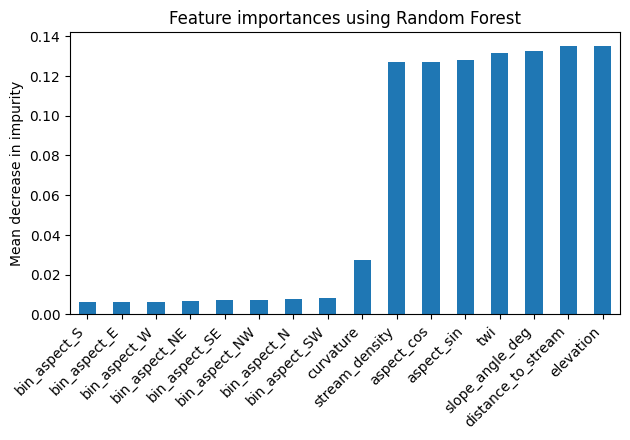

In [ ]:
forest_importances = pd.Series(importances, index=features)

forest_importances = forest_importances.sort_values()
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using Random Forest")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.xticks(rotation=45, ha='right')

plt.savefig(os.path.join(plot_path, 'random_forest_feature_importance.png'))

plt.show()

0: elevation  
1: curvature  
2,3: aspect: cos and sin  
4-11: bin_aspect: N, NE, E, SE, S, SW, W, NW  
12: slope_angle_deg  
13: log_slope  
14: stream_density  
15: distance_to_stream  
16: twi

In [ ]:
%%time
y_pred = clf.predict(X)

CPU times: user 1min 12s, sys: 7.76 s, total: 1min 20s
Wall time: 1min 20s


In [ ]:
result_map = np.zeros_like(shape_mask, dtype=y_pred.dtype)
result_map[~shape_mask] = y_pred

In [ ]:
np.sum(y_pred), np.sum(result_map)

(4468881, 4468881)

In [ ]:
fn = f"random_forest_boost_{boost_param}_max_depth_{max_depth}"
save_array_as_npy(result_map, fn)

shape of random_forest_boost_8_max_depth_12 (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/Outputs/random_forest_boost_8_max_depth_12.npy


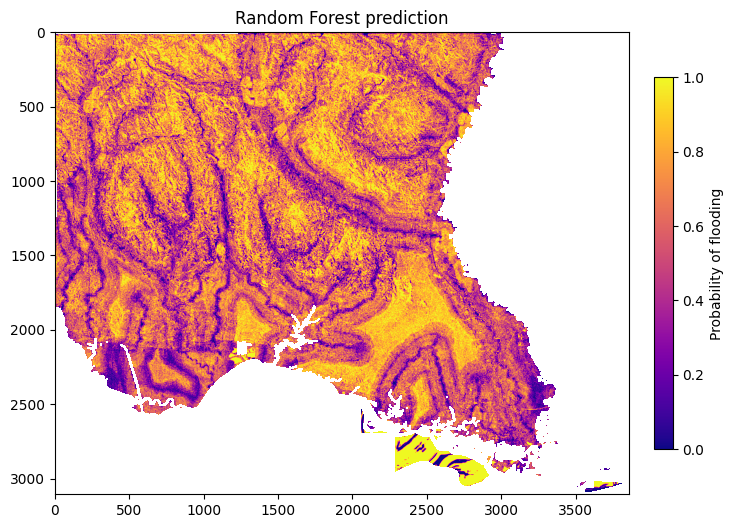

In [ ]:
plot_result_map(result_map,
                title='Random Forest prediction',
                colorbar_label='Probability of flooding',
                filename=os.path.join(plot_path, 'random_forest_map.png'),
                cmap='plasma',
                scatter_df=False)

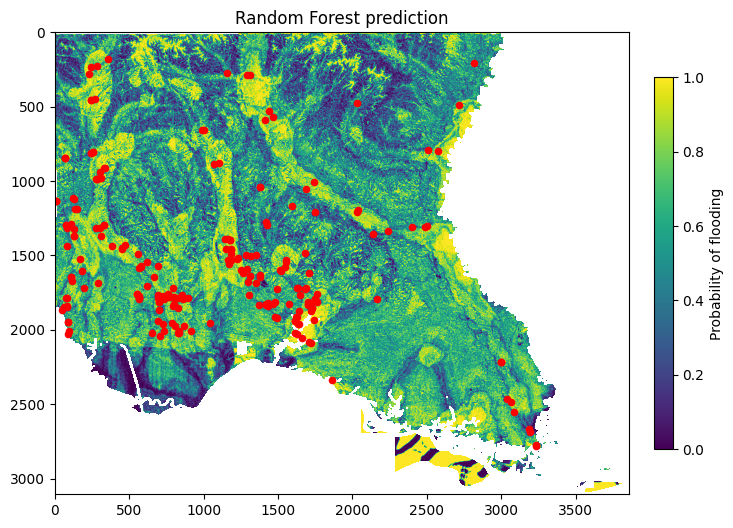

In [ ]:
plot_result_map(result_map,
                title='Random Forest prediction',
                colorbar_label='Probability of flooding',
                filename=os.path.join(plot_path, 'random_forest_map.png'),
                #cmap='plasma',
                scatter_df=True)

### Gaussian Mixture Model

In [ ]:
# guassian mixture classification

from sklearn.mixture import GaussianMixture

clf = GaussianMixture(n_components=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

metrics = performance_metrics(y_pred, y_test)

print(f"Recall: {metrics['recall']:.2f}")

Recall: 0.54


In [ ]:
%%time
y_pred = clf.predict(X)

CPU times: user 2.72 s, sys: 2.04 s, total: 4.75 s
Wall time: 5.43 s


In [ ]:
result_map = np.zeros_like(shape_mask, dtype=y_pred.dtype)
result_map[~shape_mask] = y_pred

In [ ]:
%%time
from scipy.signal import medfilt

med_result_map = medfilt(result_map, 9)

CPU times: user 7.77 s, sys: 103 ms, total: 7.87 s
Wall time: 8.11 s


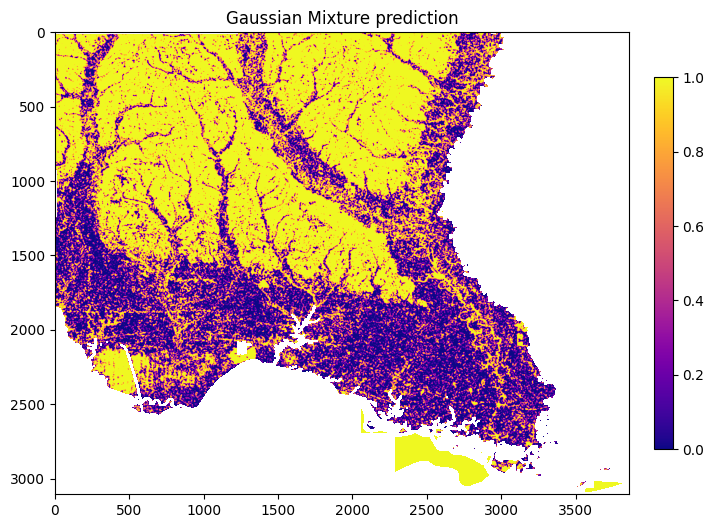

In [ ]:
plot_result_map(med_result_map,
                title='Gaussian Mixture prediction',
                #colorbar_label='Probability of flooding',
                #filename=os.path.join(plot_path, 'random_forest_map.png'),
                cmap='plasma',
                scatter_df=False)

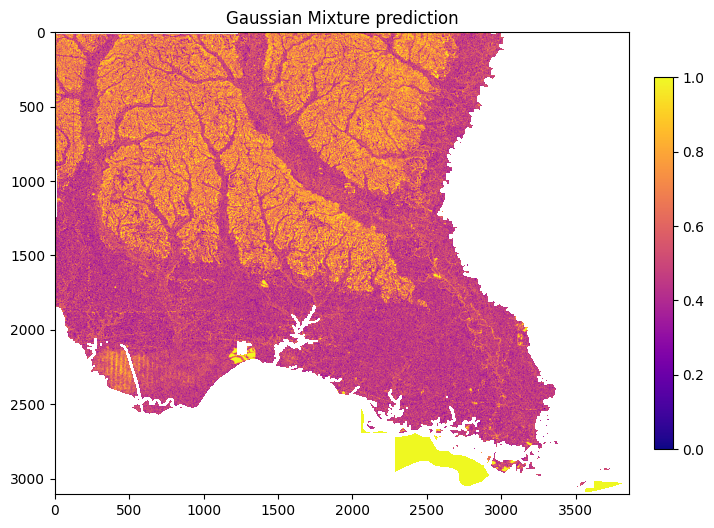

In [ ]:
plot_result_map(result_map,
                title='Gaussian Mixture prediction',
                #colorbar_label='Probability of flooding',
                #filename=os.path.join(plot_path, 'random_forest_map.png'),
                cmap='plasma',
                scatter_df=False)

### clustering

(array([52., 62., 30., 25., 14., 13., 10.,  6.,  5.,  4.,  0.,  3.,  2.,
         2.,  2.,  2.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.00219131, 0.00438263, 0.00657394, 0.00876526,
        0.01095657, 0.01314788, 0.0153392 , 0.01753051, 0.01972182,
        0.02191314, 0.02410445, 0.02629577, 0.02848708, 0.0306784 ,
        0.03286971, 0.03506102, 0.03725234, 0.03944365, 0.04163497,
        0.04382628]),
 <BarContainer object of 20 artists>)

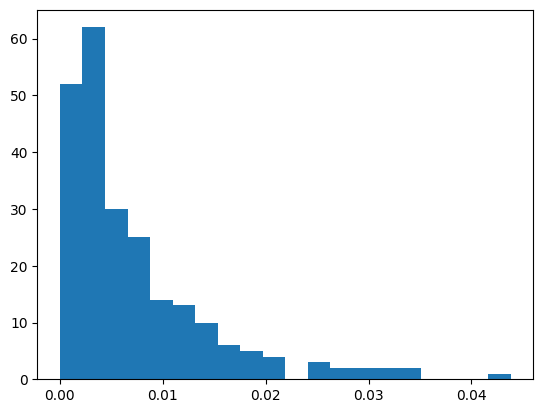

In [ ]:
plt.hist(distance_to_stream[~shape_mask][y], bins=20)

### K-Means algorithm

In [ ]:
X_floods = X[y]
X_floods.shape

(233, 8)

In [ ]:
# Clustering of X_floods to get the centroids
from sklearn.cluster import KMeans

n_clusters=5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_floods)
centroids = kmeans.cluster_centers_
centroids.shape

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


(5, 8)

In [ ]:
# which points are in which cluster
kmeans.labels_.shape

(233,)

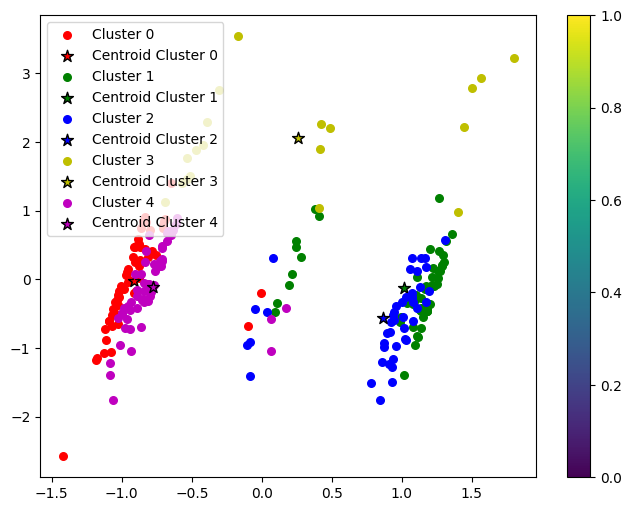

In [ ]:
# plot the centroids with PCA transformation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_floods)

centroids_pca = pca.transform(centroids)
colors = ['r', 'g', 'b', 'y', 'm']

plt.figure(figsize=(8, 6))
for k in range(n_clusters):
    plt.scatter(X_pca[kmeans.labels_==k, 0], X_pca[kmeans.labels_==k, 1], c=colors[k], s=30)
    plt.scatter(centroids_pca[k, 0], centroids_pca[k, 1], c=colors[k], s=80,
                marker="*", edgecolors='k',
                )
plt.colorbar()
plt.legend(['Cluster 0', 'Centroid Cluster 0',
            'Cluster 1', 'Centroid Cluster 1',
            'Cluster 2', 'Centroid Cluster 2',
            'Cluster 3', 'Centroid Cluster 3',
            'Cluster 4', 'Centroid Cluster 4'],
           loc='upper left')
plt.show()

In [ ]:
centroid = centroids[0]
centroid

array([ 0.17758577, -0.27272727,  0.2404385 , -0.03339808,  0.10558755,
        0.44641561,  0.09111297,  2.14775263])

In [ ]:
(X - centroid).shape

(7442458, 8)

In [ ]:
np.linalg.norm(X - centroid, axis=1)

(7442458,)

In [ ]:
k = 0
c = 5
np.exp(-np.linalg.norm(X_floods[kmeans.labels_==k] - centroids[k], axis=1)/c).mean()

0.8275139418921

In [ ]:
# scale is chosen so that the prob is ~ 90% for flood events in the right cluster
scale = [5, 5, 5, 5, 5]

prob_maps = []
for k in range(n_clusters):
    centroid = centroids[k]
    c = scale[k]
    result_map = np.zeros_like(shape_mask, dtype=float)
    result_map[~shape_mask] = np.exp(-np.linalg.norm(X - centroid, axis=1) / c)

    prob_maps.append(result_map)

    plot_result_map(result_map,
                    title=f'Distance to the centroid {k}',
                    colorbar_label='Distance to the centroid',
                    #filename=os.path.join(plot_path, 'distance_to_centroid_map.png'),
                    #cmap='plasma',
                    scatter_df=False)

Output hidden; open in https://colab.research.google.com to view.

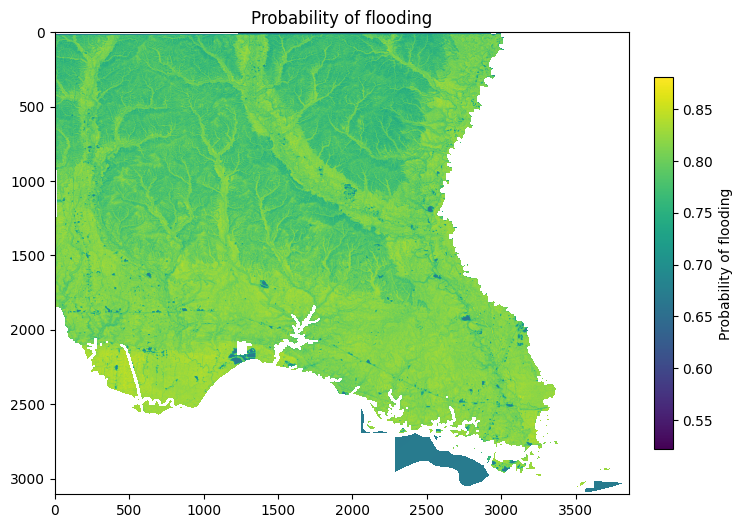

In [ ]:
prob_map = np.array([0.1, 0.1, 0.1, 0.6, 0.1]).reshape(1,5).dot(np.array(prob_maps).reshape(5,-1)).reshape(shape_mask.shape)

plot_result_map(prob_map,
                title='Probability of flooding',
                colorbar_label='Probability of flooding',
                #filename=os.path.join(plot_path, 'probability_map.png'),
                #cmap='plasma',
                scatter_df=False)

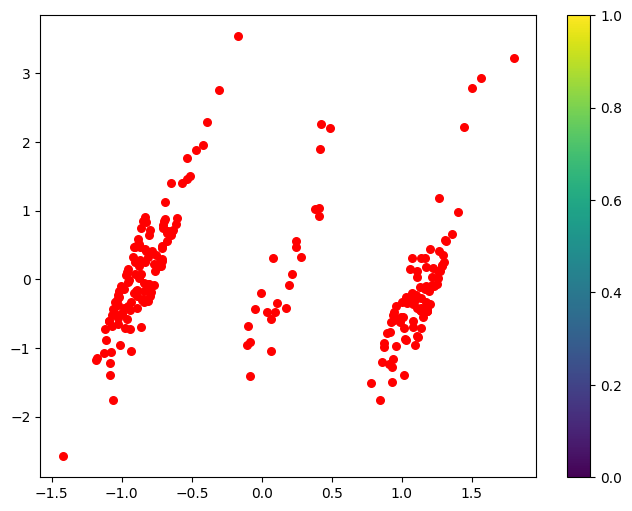

In [ ]:
# pca on X_floods and plot
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_floods)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='r', s=30)
plt.colorbar()
plt.show()

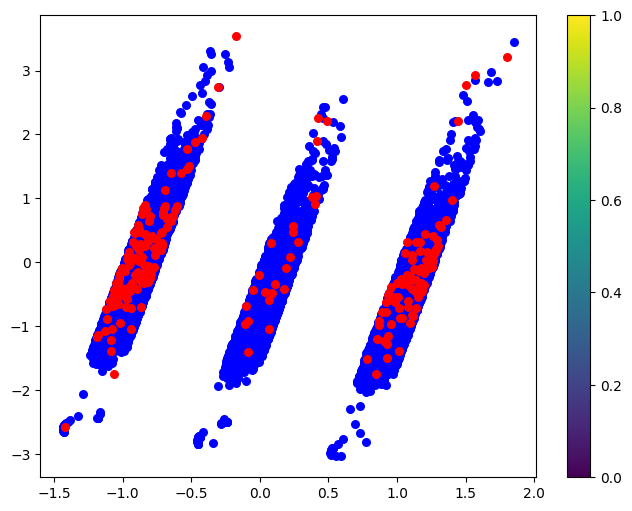

In [ ]:
X_non_floods = X[~y][300_000:310_000]

pca_non_result = pca.transform(X_non_floods)

plt.figure(figsize=(8, 6))
plt.scatter(pca_non_result[:, 0], pca_non_result[:, 1], c='b', s=30)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='r', s=30)
plt.colorbar()
plt.show()

### HMM

nothing yet

### Merge all the output maps (Ensemble learning)

nothing yet

# Plot the data maps

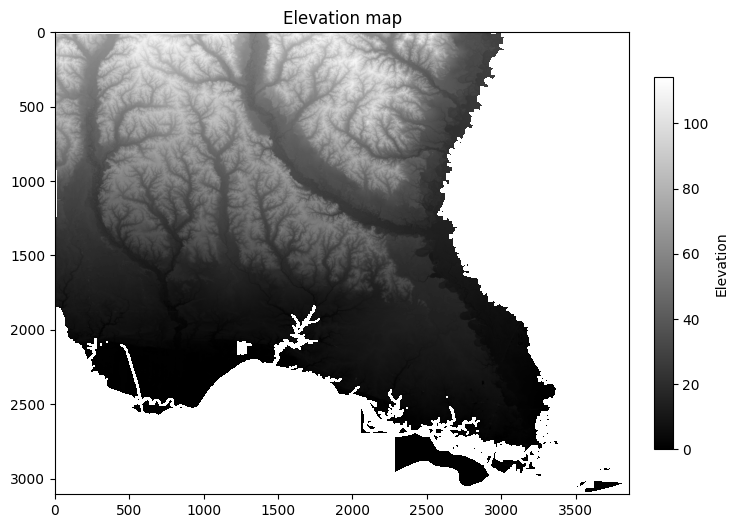

In [ ]:
# plot the elevation map
fig, ax = plt.subplots(figsize=(8, 6))

masked_elevation = np.ma.array(elevation, mask = shape_mask)
img = ax.imshow(masked_elevation, cmap='gray')
cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Elevation')

plt.title('Elevation map')

plt.savefig(os.path.join(plot_path, 'elevation_map.png'))
plt.show()

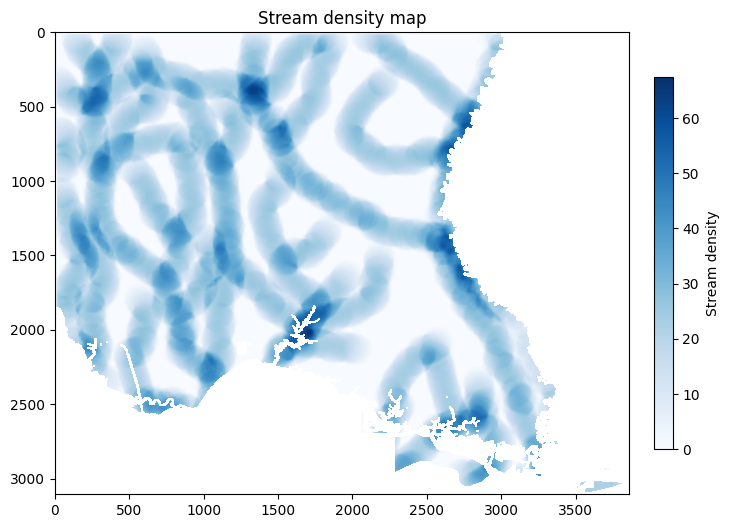

In [ ]:
# plot the stream density map

fig, ax = plt.subplots(figsize=(8, 6))

masked_stream_density = np.ma.array(stream_density, mask = shape_mask)
img = ax.imshow(masked_stream_density, cmap='Blues')
cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Stream density')

plt.title('Stream density map')

plt.savefig(os.path.join(plot_path, 'stream_density_map.png'))
plt.show()

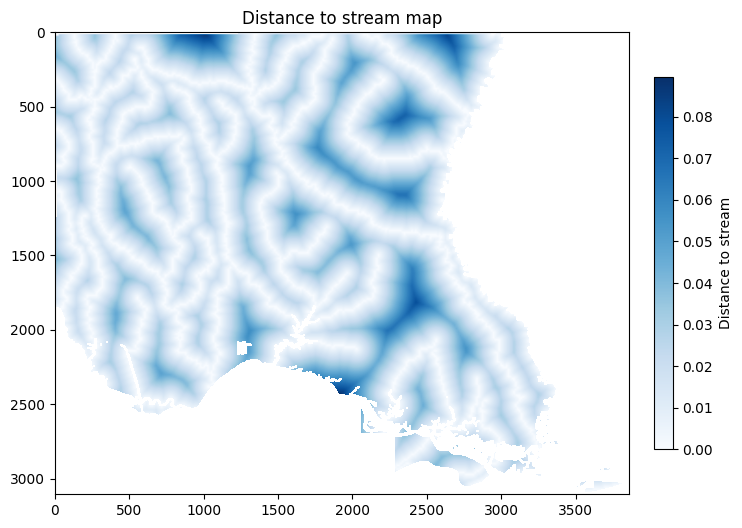

In [ ]:
# plot the distance to stream map

fig, ax = plt.subplots(figsize=(8, 6))

masked_distance_to_stream = np.ma.array(distance_to_stream, mask = shape_mask)
img = ax.imshow(masked_distance_to_stream, cmap='Blues')
cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Distance to stream')

plt.title('Distance to stream map')

plt.savefig(os.path.join(plot_path, 'distance_to_stream_map.png'))
plt.show()

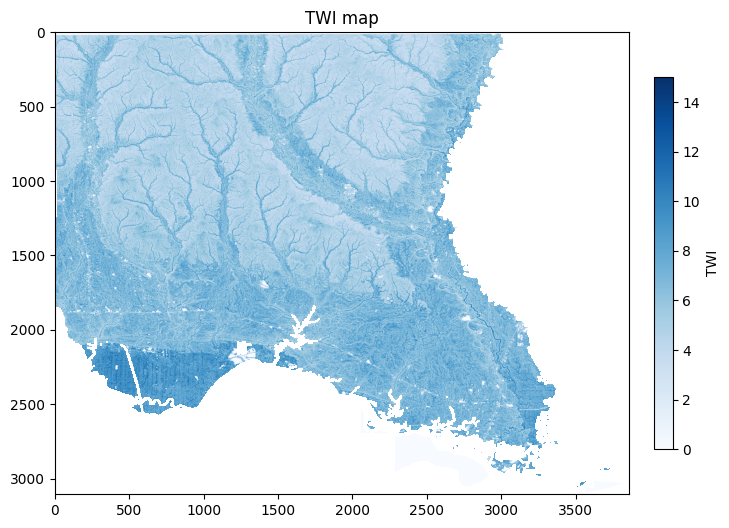

In [ ]:
# plot the twi map

fig, ax = plt.subplots(figsize=(8, 6))

masked_twi = np.ma.array(twi.clip(-10, 15), mask = shape_mask)
img = ax.imshow(masked_twi, cmap='Blues')
cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('TWI')

plt.title('TWI map')

plt.savefig(os.path.join(plot_path, 'twi_map.png'))
plt.show()

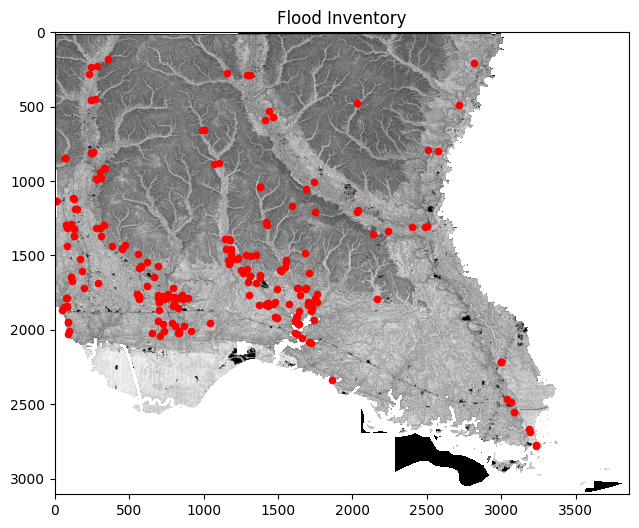

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

c = 'red'

masked_twi = np.ma.array(twi.clip(-10, 10), mask = shape_mask)
img = ax.imshow(masked_twi, cmap='gray')

plt.title('Flood Inventory')

ax.scatter(df.to_numpy()[:,1], df.to_numpy()[:,0],
           c=c,
           #edgecolors='black',
           s=20)

plt.savefig(os.path.join(plot_path, f'flood_inventory_{c}.png'))
plt.show()

## Dumb model
wanna try something

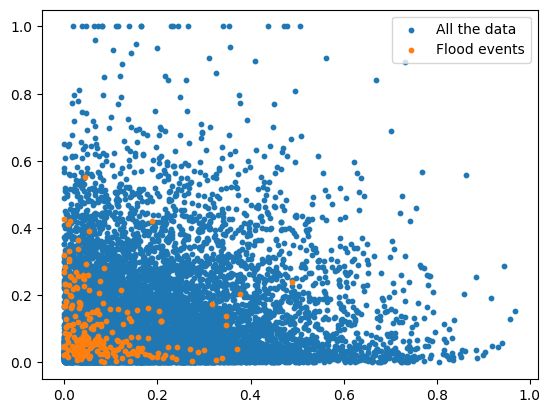

In [ ]:
# scatter data using the supposedly two most important features

n = 10_000
s = 10
plt.scatter(np.random.choice(norm_distance_to_stream[~shape_mask],
                             size=n,
                             replace=False),
            np.random.choice(norm_slope_angle_deg[~shape_mask],
                             size=n,
                             replace=False),
            label="All the data",
            s=s)

plt.scatter(norm_distance_to_stream[flood_map],
            norm_slope_angle_deg[flood_map],
            label="Flood events",
            s=s)

plt.legend()
plt.show()

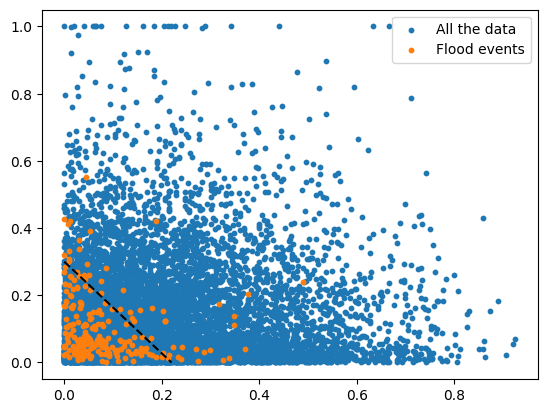

In [ ]:
# scatter data using the supposedly two most important features

n = 10_000
s = 10
plt.scatter(np.random.choice(norm_distance_to_stream[~shape_mask],
                             size=n,
                             replace=False),
            np.random.choice(norm_slope_angle_deg[~shape_mask],
                             size=n,
                             replace=False),
            label="All the data",
            s=s)

plt.scatter(norm_distance_to_stream[flood_map],
            norm_slope_angle_deg[flood_map],
            label="Flood events",
            s=s)

x1, y1 = 0, 0.3
x2, y2 = 0.22, 0
plt.plot([x1, x2], [y1, y2], 'k--')
plt.legend()
plt.show()

In [ ]:
def dumb_model(X):
    y = X[:,0]/0.2 + X[:,1]/0.2 <= 1
    return y

y_pred = dumb_model(X)
y_pred.shape

(7442458,)

In [ ]:
result_map = np.zeros_like(shape_mask, dtype=y_pred.dtype)
result_map[~shape_mask] = y_pred

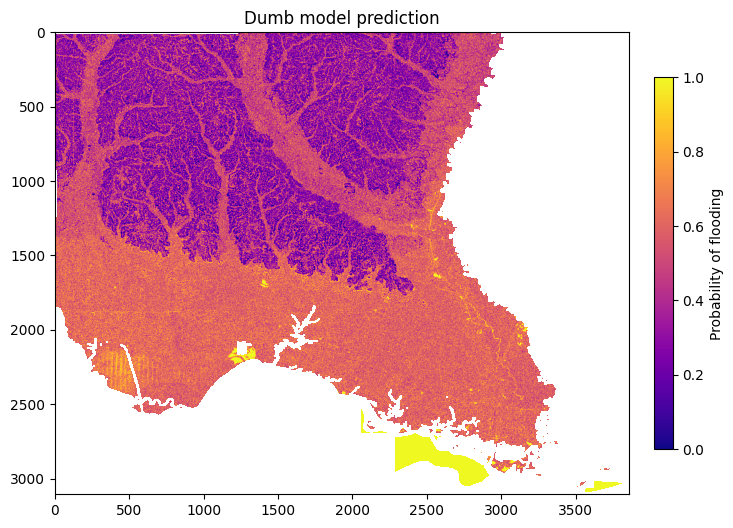

In [ ]:
plot_result_map(result_map,
                title='Dumb model prediction',
                colorbar_label='Probability of flooding',
                #filename=os.path.join(plot_path, 'random_forest_map.png'),
                cmap='plasma',
                scatter_df=False)

# Fake HMM

Flooding area: 77.99 %


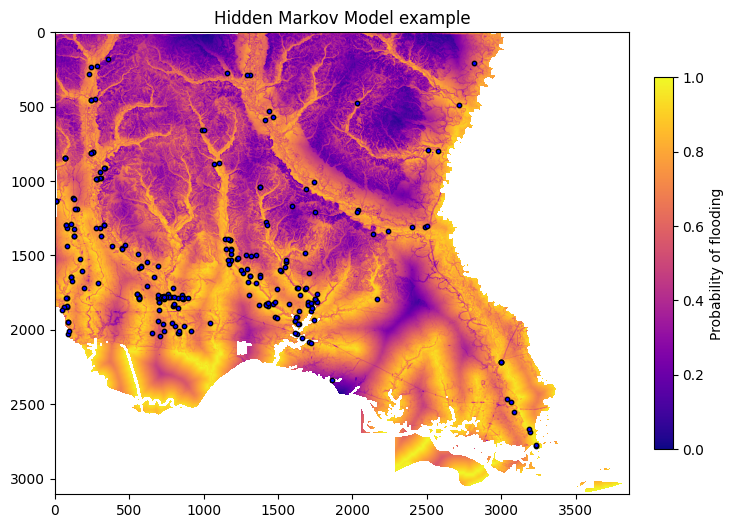

In [ ]:
hmm_map = (1 - norm_distance_to_stream) * (1 - norm_slope_angle_deg)**2 * \
            (1 - norm_elevation)**0.2

print(f"Flooding area: {np.sum(hmm_map >= 0.5) / np.prod(hmm_map.shape) *100:.2f} %")
cmap = 'plasma'
# plot the hmm map
fig, ax = plt.subplots(figsize=(8, 6))

masked_hmm_map = np.ma.array(hmm_map, mask = shape_mask)
img = ax.imshow(masked_hmm_map, cmap=cmap)
cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Probability of flooding')

plt.title('Hidden Markov Model example')

ax.scatter(df.to_numpy()[:,1], df.to_numpy()[:,0],
           c='blue',
           edgecolors='black',
           s=10)

plt.savefig(os.path.join(plot_path, f'hmm_map_example_{cmap}.png'))
plt.show()

In [ ]:
save_array_as_npy(hmm_map, 'fake_map')

shape of fake_map (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/Outputs/fake_map.npy


# Instructions for presentation

Please find your group number from Coursework or the spreadsheet
5 minutes (4 Slides + QA) each group:

[Slide 1: Introduction of your problem]  -	Explain what your project is

[Slide 2: Presentation of your dataset]  -	What your dataset is

[Slide 3: Presentation of your algorithm]  - What question would you like to answer with your algorithm? Inputs and Outputs? Supervised or Unsupervised? End goal of your final results?

[Slide 4: summary of your results]  -	Do the results meet your expectations?



$$
x_i = \begin{bmatrix} x_i^{(1)} \\ x_i^{(2)}\\ x_i^{(K)} \end{bmatrix}$$

# Trash bin section


* Increase F1 score and recall as much as possible
* Doesn't matter if precision goes down

F1 score: 0.11
Recall: 0.23
Precision: 0.07


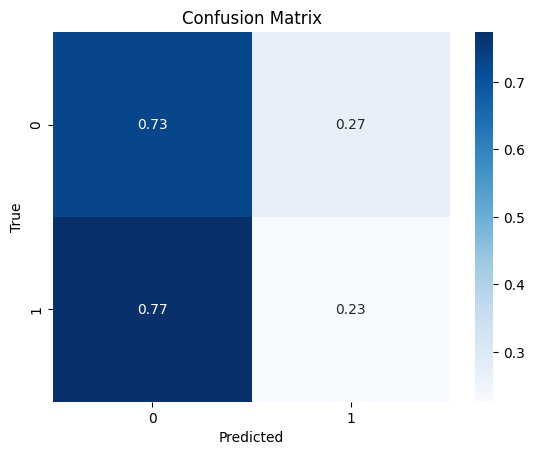

In [ ]:
metrics = performance_metrics(y_pred, y_test)

print(f"F1 score: {metrics['f1']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")
print(f"Precision: {metrics['precision']:.2f}")

sns.heatmap(metrics['confusion_matrix'], annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

F1 score: 0.09
Recall: 0.23
Precision: 0.06


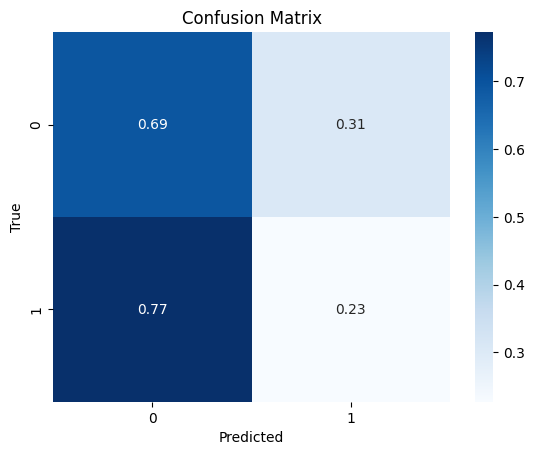

In [ ]:
metrics = performance_metrics(y_pred, y_test)

print(f"F1 score: {metrics['f1']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")
print(f"Precision: {metrics['precision']:.2f}")

sns.heatmap(metrics['confusion_matrix'], annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
n_datapoints = 3_000
X_select, y_select = select_points(X, y, n_datapoints)

X_train, X_test, y_train, y_test = train_test_split(X_select,
                                                    y_select,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
%%time
flood_boosting = np.arange(1, 31)
all_metrics = []

for nb_flood_rep in flood_boosting:

    X_boost, y_boost = boost_flood(X_train, y_train, nb_flood_rep)

    clf = XGBClassifier()
    clf.fit(X_boost, y_boost)

    y_pred = clf.predict(X_test)

    metrics = performance_metrics(y_pred, y_test)
    all_metrics.append(metrics)

CPU times: user 15.9 s, sys: 43.7 ms, total: 15.9 s
Wall time: 10.6 s


In [ ]:
f1_scores = np.array([m['f1'] for m in all_metrics])
recall_scores = np.array([m['recall'] for m in all_metrics])
precision_scores = np.array([m['precision'] for m in all_metrics])

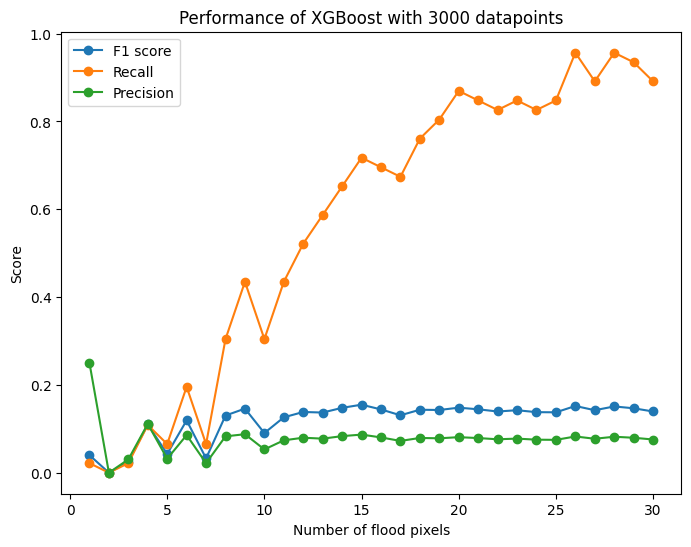

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(flood_boosting, f1_scores, '-o')
plt.plot(flood_boosting, recall_scores, '-o')
plt.plot(flood_boosting, precision_scores, '-o')
plt.xlabel('Number of flood pixels')
plt.ylabel('Score')
plt.legend(['F1 score', 'Recall', 'Precision'])
plt.title(f'Performance of XGBoost with {n_datapoints} datapoints')
plt.show()

## Cross validation with XGBoost

In [ ]:
n_datapoints = 3_000

X_select, y_select = select_points(X, y, n_datapoints)

In [ ]:
print(f"X shape: {X_select.shape}")
print(f"y shape: {y_select.shape}")
print(f"Number of flood pixels: {np.count_nonzero(y_select)}")

X shape: (3000, 16)
y shape: (3000,)
Number of flood pixels: 236


In [ ]:
%%time
# use xgboost for binary classification
# using cross validation

from sklearn.model_selection import StratifiedKFold

n_splits = 9
nb_flood_rep = 8

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

all_metrics = []

for i, (train_index, test_index) in enumerate(skf.split(X_select, y_select)):
    print(f"Fold {i+1}/{n_splits}")
    X_train, X_test = X_select[train_index], X_select[test_index]
    y_train, y_test = y_select[train_index], y_select[test_index]

    X_train, y_train = boost_flood(X_train, y_train,
                                   nb_flood_rep=nb_flood_rep)

    clf = XGBClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(np.sum(y_pred))
    print(np.sum(y_test))

    metrics = performance_metrics(y_pred, y_test)

    metrics['ratio_flood'] = np.count_nonzero(y_test) / len(y_test)
    all_metrics.append(metrics)

Fold 1/9
103
27
Fold 2/9
90
27
Fold 3/9
107
26
Fold 4/9
97
26
Fold 5/9
105
26
Fold 6/9
99
26
Fold 7/9
106
26
Fold 8/9
98
26
Fold 9/9
111
26
CPU times: user 8.15 s, sys: 12.4 ms, total: 8.17 s
Wall time: 6.7 s


In [ ]:
f1_scores = np.array([m['f1'] for m in all_metrics])
recall_scores = np.array([m['recall'] for m in all_metrics])
precision_scores = np.array([m['precision'] for m in all_metrics])

print(f"F1 score : {[round(m['f1'],2) for m in all_metrics]}")
print(f"Recall   : {[round(m['recall'],2) for m in all_metrics]}")
print(f"Precision: {[round(m['precision'],2) for m in all_metrics]}")

F1 score : [0.09, 0.1, 0.17, 0.1, 0.17, 0.18, 0.08, 0.16, 0.13]
Recall   : [0.22, 0.22, 0.42, 0.23, 0.42, 0.42, 0.19, 0.38, 0.35]
Precision: [0.06, 0.07, 0.1, 0.06, 0.1, 0.11, 0.05, 0.1, 0.08]


In [ ]:
print(f"F1 score : min {f1_scores.min():.2f} mean {f1_scores.mean():.2f} "
      f"max {f1_scores.max():.2f} std {f1_scores.std():.2f}")
print(f"Recall   : min {recall_scores.min():.2f} mean {recall_scores.mean():.2f} "
      f"max {recall_scores.max():.2f} std {recall_scores.std():.2f}")
print(f"Precision: min {precision_scores.min():.2f} "
      f"mean {precision_scores.mean():.2f} "
      f"max {precision_scores.max():.2f} std {precision_scores.std():.2f}")

F1 score : min 0.08 mean 0.13 max 0.18 std 0.04
Recall   : min 0.19 mean 0.32 max 0.42 std 0.09
Precision: min 0.05 mean 0.08 max 0.11 std 0.02


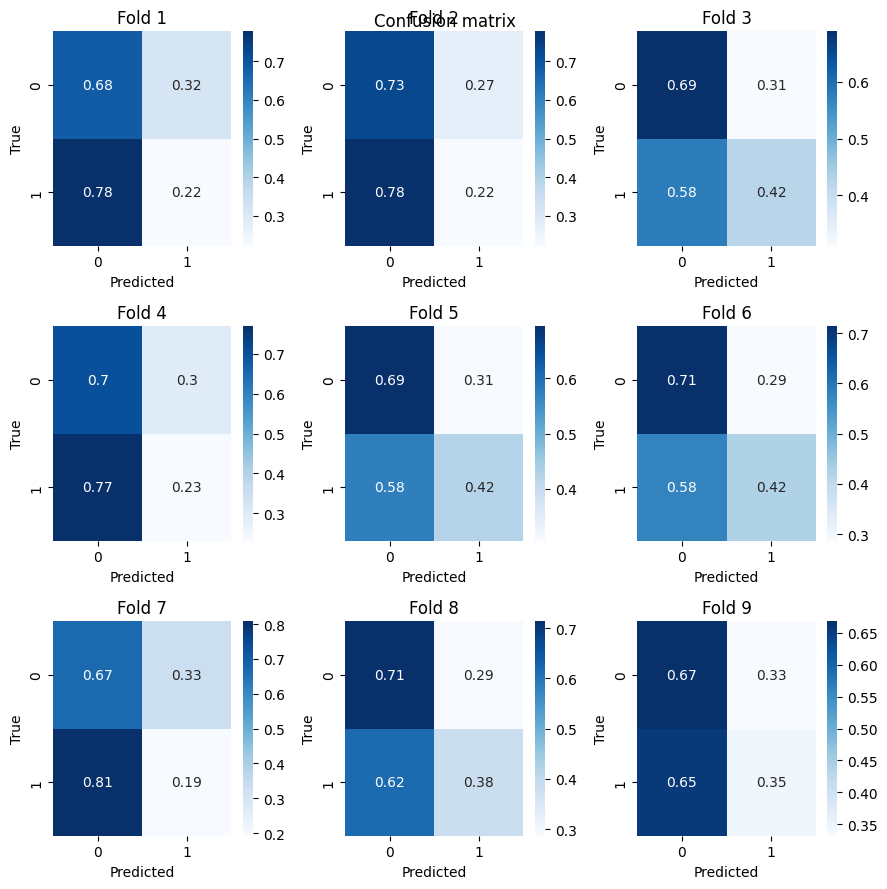

In [ ]:
# plot confusion matrices

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
ax = ax.ravel()

for i in range(n_splits):
    sns.heatmap(all_metrics[i]['confusion_matrix'], annot=True, cmap='Blues', ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].set_title(f'Fold {i+1}')
plt.tight_layout()
plt.suptitle('Confusion matrix')
plt.show()